<a href="https://colab.research.google.com/github/vicentcamison/idal_ia3/blob/main/3%20Aprendizaje%20profundo%20(II)/Sesion%202/Alien_vs_predator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import optim

import pip

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Inicialización de Kaggle para descargar el dataset

In [3]:
!pip install -q kaggle
from google.colab import files
files.upload()
#de aquí, hay que seleccionar el archivo json de Kaggle

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"juanvicent","key":"03ce56503ecba63c72b5177d4c89f358"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
#Make directory named kaggle and copy kaggle.json file there
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d pmigdal/alien-vs-predator-images

 64% 9.00M/14.1M [00:00<00:00, 50.1MB/s]
100% 14.1M/14.1M [00:00<00:00, 56.3MB/s]


In [6]:
! mkdir avp_data/
! unzip alien-vs-predator-images.zip -d avp_data/

Archive:  alien-vs-predator-images.zip
  inflating: avp_data/alien_vs_predator_thumbnails/data/train/alien/0.jpg  
  inflating: avp_data/alien_vs_predator_thumbnails/data/train/alien/1.jpg  
  inflating: avp_data/alien_vs_predator_thumbnails/data/train/alien/10.jpg  
  inflating: avp_data/alien_vs_predator_thumbnails/data/train/alien/100.jpg  
  inflating: avp_data/alien_vs_predator_thumbnails/data/train/alien/101.jpg  
  inflating: avp_data/alien_vs_predator_thumbnails/data/train/alien/102.jpg  
  inflating: avp_data/alien_vs_predator_thumbnails/data/train/alien/103.jpg  
  inflating: avp_data/alien_vs_predator_thumbnails/data/train/alien/104.jpg  
  inflating: avp_data/alien_vs_predator_thumbnails/data/train/alien/105.jpg  
  inflating: avp_data/alien_vs_predator_thumbnails/data/train/alien/106.jpg  
  inflating: avp_data/alien_vs_predator_thumbnails/data/train/alien/107.jpg  
  inflating: avp_data/alien_vs_predator_thumbnails/data/train/alien/108.jpg  
  inflating: avp_data/alien_vs

Ya hemos cargado satisfactoriamente el dataset. Ahora trabajemos para aplicar las transformaciones correspondientes (Hacer que todas las imágenes sean cuadradas)

In [29]:
normalize_mean = 0.5
normalize_std = 0.5

transform = transforms.Compose([
  transforms.CenterCrop(224),
  transforms.ToTensor(),  
  transforms.Normalize(mean=normalize_mean, std=normalize_std)
])

#transform = torch.nn.Sequential(
#    transforms.ToTensor(),
#    transforms.CenterCrop(224),
#    transforms.Normalize(mean=normalize_mean, std=normalize_std)
#)

Creamos los conjuntos de train y test, y los iteradores correspondientes

In [31]:
batch_size=32

train = torchvision.datasets.ImageFolder(root = "avp_data/data/train", transform=transform)
trainloader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=2)

test = torchvision.datasets.ImageFolder(root = 'avp_data/data/validation', transform=transform)
testloader = DataLoader(test, batch_size=batch_size, shuffle=True, num_workers=2)

Mostramos por pantalla algunas de las imágenes ejemplo

In [9]:
trainloader.generator

TypeError: ignored

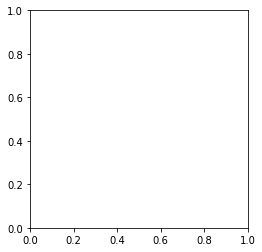

In [10]:
plt.imshow(train.imgs[0])

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fd5aaec5b70>>
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fd5aaec5b70>>
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
    self._shutdown_workers()
  File "/usr/local/lib/p

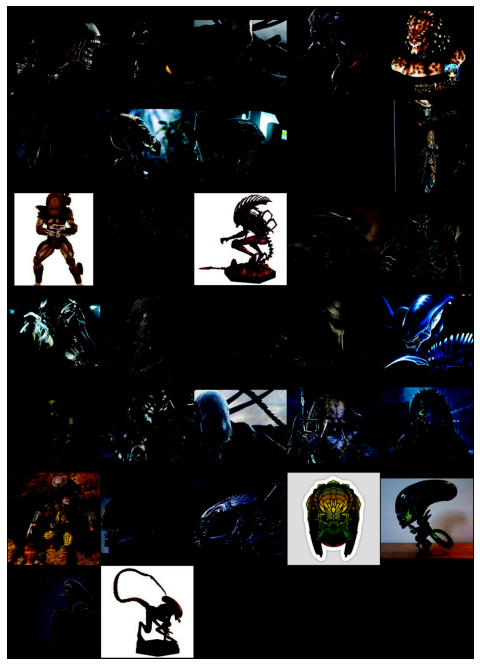

In [32]:
for X, Y in trainloader:
  plt.figure(figsize=(12,12))
  grid = torchvision.utils.make_grid(X, nrow=int(np.sqrt(len(X))))
  plt.imshow(grid.permute(1,2,0))
  plt.axis('off')
  plt.show()
  break

# Transfer learning con VGG19

In [11]:
# Cargamos el modelo basado en VGG19
vgg_based = torchvision.models.vgg19(pretrained=True)
print(vgg_based)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), pad

In [14]:
# Congelamos las capas
for param in vgg_based.parameters():
  param.requires_grad = False

# Modificamos la última capa
number_features = vgg_based.classifier[6].in_features #n1 de features de salida que tiene el VGG19
classes = 2 #numero de clases de salida que tiene el clasificador de aliens y predators que queremos construir

layers = list(vgg_based.classifier.children())[:-1] #Quitamos la última capa
#layers.extend([torch.nn.Linear(number_features, len(class_names))]) ESTE CÓDIGO DEBERÁ FUNCIONAR Y NO LO HACE, ME HABRÉ DEJADO ALGO
layers.extend([torch.nn.Linear(number_features, 2)])
vgg_based.classifier = torch.nn.Sequential(*layers)

vgg_based = vgg_based.to(device)

print(vgg_based)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg_based.parameters(), lr=0.001, momentum=0.9)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

Ya tenemos la red, ahora pasamos a crear el bucle de entrenamiento

In [33]:
vgg_based.train()
train_loss = []
epochs = 10
for epoch in range(epochs):

  running_loss = 0.0
  for data in trainloader:
    #cogemos los inputs como una lista de [inputs, labels]
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    #hacemos 0 los parámetros del gradiente
    optimizer.zero_grad()
    #forward + backward + optimize
    outputs = vgg_based(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    #el loss se devuelve como una media sobre el batch_size: deshacemos la media
    running_loss += loss.item() * inputs.size(0)

  loss = running_loss / len(trainloader)
  train_loss.append(loss)
  print('epoch [%d/%d] loss: %.3f' %
        (epoch + 1, epochs, loss))
  
print('Finished Training')

epoch [1/10] loss: 14.572
epoch [2/10] loss: 7.820
epoch [3/10] loss: 6.964
epoch [4/10] loss: 6.281
epoch [5/10] loss: 5.962
epoch [6/10] loss: 5.922
epoch [7/10] loss: 5.810
epoch [8/10] loss: 5.639
epoch [9/10] loss: 5.529
epoch [10/10] loss: 5.911
Finished Training


Y ahora creamos todo lo relacionado con el test

In [37]:
vgg_based.eval()
correct = 0
total = 0
with torch.no_grad():
  for data in testloader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    outputs = vgg_based(images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the test images: %d %%' % (
      100 * correct / total))

Accuracy of the network on the test images: 93 %


# Ejercicio: Transfer learning con ResNet50
Importamos el modelo de Transfer learning ResNet50 y resolvemos algunas cuestiones propuestas

In [38]:
#cargamos el modelo basado en ResNet50
rn50_based = torchvision.models.resnet50(pretrained=True)
print(rn50_based)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

**¿Cuántos canales de entrada tiene la última capa (fc)? ¿Cuántos de salida?**
Tiene 2048 de entrada y 1000 de salida

**Congela los pesos de la red y sustituye la última capa (fc) por el siguiente bloque secuencial de 2 salidas:**
Usaremos parte del código que se usó en el ejercicio anterior

In [41]:
#(Estas son las capas que hay que añadir al final. Estas capas SÍ son entrenables)
rn50_based.fc = torch.nn.Sequential(
    nn.Linear(2048, 128)
    nn.ReLU(inplace=True)
    nn.Linear(128,2))

ModuleAttributeError: ignored

In [43]:
rn50_based.fc #parece que este código hace referencia a la última capa de la resnet
# ¿Se puede acceder al resto de capas de la ResNet de forma similar?

Linear(in_features=2048, out_features=1000, bias=True)

In [44]:
rn50_based.layer3 #Sï, eso parece. Cómo acceder ya al interior de estas no lo sé...

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Co

In [46]:
rn50_based.layer3[5].conv1 #vale, son un vector. Se puede entrar en ellas fácilmente

Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)

In [50]:
# Congelamos las capas
for param in rn50_based.parameters():
  param.requires_grad = False

# Modificamos la última capa
number_features = rn50_based.fc.in_features #n1 de features de salida que tiene el VGG19
classes = 2 #numero de clases de salida que tiene el clasificador de aliens y predators que queremos construir

#layers = list(rn50_based.classifier.children())[:-1] #Quitamos la última capa
#layers.extend([torch.nn.Linear(number_features, len(class_names))]) ESTE CÓDIGO DEBERÁ FUNCIONAR Y NO LO HACE, ME HABRÉ DEJADO ALGO
#layers.extend([torch.nn.Sequential(
#    nn.Linear(2048, 128),
#    nn.ReLU(inplace=True),
#    nn.Linear(128,2))])
#rn50_based.classifier = torch.nn.Sequential(*layers)

rn50_based.fc = torch.nn.Sequential(
    torch.nn.Linear(2048, 128),
    torch.nn.ReLU(inplace=True),
    torch.nn.Linear(128,2))

rn50_based = rn50_based.to(device)

In [51]:
print(rn50_based)
#podemos comprobar que sí que hemos añadido las nuevas capas correctamente

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

**Entrena el modelo** El código siguiente es copia pega de los bucles de entrenamiento y test que he puesto antes

In [54]:
## BUCLE DE ENTRENAMIENTO

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(rn50_based.parameters(), lr=0.001)

rn50_based.train()
train_loss = []
epochs = 25
for epoch in range(epochs):

  running_loss = 0.0
  for data in trainloader:
    #cogemos los inputs como una lista de [inputs, labels]
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    #hacemos 0 los parámetros del gradiente
    optimizer.zero_grad()
    #forward + backward + optimize
    outputs = rn50_based(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    #el loss se devuelve como una media sobre el batch_size: deshacemos la media
    running_loss += loss.item() * inputs.size(0)

  loss = running_loss / len(trainloader)
  train_loss.append(loss)
  print('epoch [%d/%d] loss: %.3f' %
        (epoch + 1, epochs, loss))
  
print('Finished Training')

epoch [1/25] loss: 18.420
epoch [2/25] loss: 9.464
epoch [3/25] loss: 8.365
epoch [4/25] loss: 8.071
epoch [5/25] loss: 4.463
epoch [6/25] loss: 5.688
epoch [7/25] loss: 4.124
epoch [8/25] loss: 4.101
epoch [9/25] loss: 3.620
epoch [10/25] loss: 5.039
epoch [11/25] loss: 3.908
epoch [12/25] loss: 2.825
epoch [13/25] loss: 3.723
epoch [14/25] loss: 2.971
epoch [15/25] loss: 3.607
epoch [16/25] loss: 3.892
epoch [17/25] loss: 2.166
epoch [18/25] loss: 3.284
epoch [19/25] loss: 2.108
epoch [20/25] loss: 1.937
epoch [21/25] loss: 2.397
epoch [22/25] loss: 1.670
epoch [23/25] loss: 4.095
epoch [24/25] loss: 2.886
epoch [25/25] loss: 3.595
Finished Training


In [55]:
## TEST

rn50_based.eval()
correct = 0
total = 0
with torch.no_grad():
  for data in testloader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    outputs = rn50_based(images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the test images: %d %%' % (
      100 * correct / total))

Accuracy of the network on the test images: 90 %
